In [1]:
import torch
import torch.nn as nn
import numpy as np
import random                                                                  
import matplotlib.pyplot as plt
torch.backends.cudnn.deterministic=True
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import math
from torch.autograd import grad
from Libraries import robotarm as ra
from Libraries import ICNN_net as net
from Libraries import ICNN_plot as pl
from Libraries import ICNN_optim_custom_penalty as opt
dtype = torch.float
device_c = torch.device("cpu")
device = torch.device("cuda:0")

In [2]:
#robot initialize
l1 = 0.3 
l2 = 0.2
m1 = 3
m2 = 2
robot = ra.robotarm(l1,l2,m1,m2,device)
xinit = torch.tensor([[-2],[2]],dtype=dtype)
#xinit = torch.tensor([[0],[3]],dtype=dtype)
xfinal = torch.tensor([[3],[3]],dtype=dtype)
#xinit = torch.tensor([[-3],[0]],dtype=dtype)
#xfinal = torch.tensor([[3],[2.5]],dtype=dtype)
T = 3
delta = 0.6
num_timesteps = 100
xpoints = np.array([  1.0,0.6,0.5,0.6,1.0])
ypoints = np.array([  1.5,1.7,1.9,2.3,2.6])
Vpoints = np.array([1.5,1.7,1.9,2.3,2.6])
#rmin,rmax,qmin,qmax,dt,qinit,qfinal,Xstable,xtraj,x_dot,qtraj,q_dot = robot.Initialize(xinit,xfinal,T,delta,num_timesteps)
rmin,rmax,qmin,qmax,dt,qinit,qfinal,Xstable,xtraj,qtraj,q_dot = robot.Initialize_spline(xpoints,ypoints,Vpoints, T, delta, num_timesteps)

#ICNN initialize
fhat_size = 1000
V_size = 300
V_hidden_sizes = [V_size, V_size]
fhat_hidden_sizes = [fhat_size,fhat_size]
tol = 0.01
alpha_net = 0.01
#getting grid data (for the regularizer)
nq1 = 100 # grid number
nq2 = 100 
nq1_b = 10 # grid number
nq2_b = 10
penalty = 5000
penalty_boundary = 100000
alpha_kinematic = 0.01
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha_net,Xstable,device) #qmin, qmax는 위에서 구함
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)
q_in_boundary,q_dot_boundary = optim_.get_boundary(nq1_b,nq2_b,qmin,qmax)
nq1_p = 100
nq2_p = 100
nx1 = 100
nx2 = 100
xmin = [-robot.l1-robot.l2, -robot.l2]
xmax = [robot.l1+robot.l2,robot.l1+robot.l2]

In [3]:
a,b,c,d,e = optim_.performance_metric(robot, q_in_reg, qtraj, q_dot,dt,q_in_boundary,q_dot_boundary, Xstable,alpha_kinematic)

#1 done
#2 done
#3 done
#4 done
#5 done


In [4]:
print(a,b,c,d,e)

tensor(1.4259, device='cuda:0') tensor(1.4200, device='cuda:0', grad_fn=<MulBackward0>) tensor(0.1397) tensor(0.0232, device='cuda:0') tensor(0.0366, device='cuda:0')


# Ploting trajectory

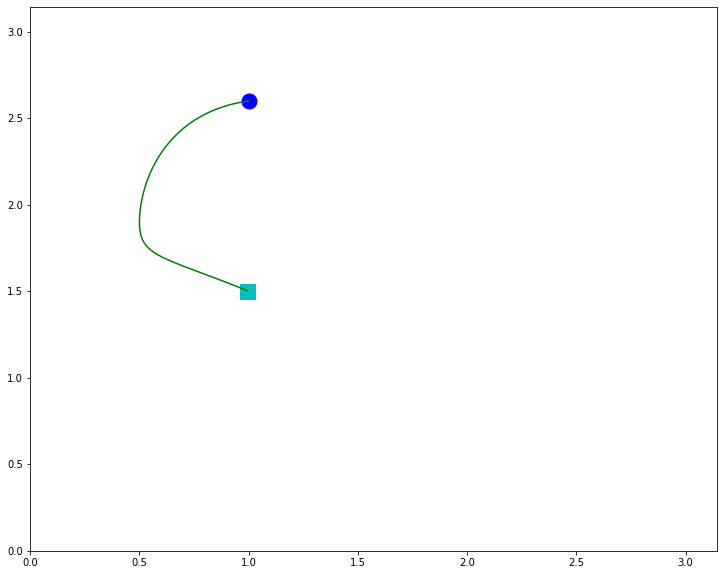

In [3]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_q_traj('qtraj.png')

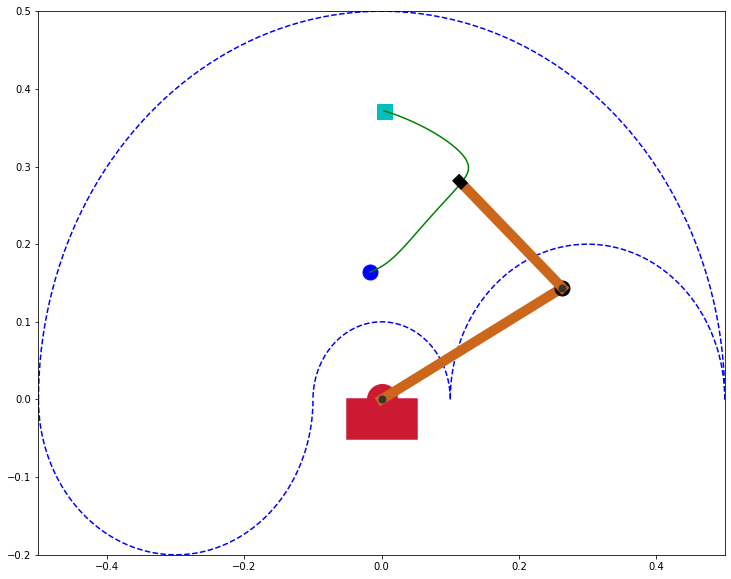

In [4]:
theta1 = xpoints[2]
theta2 = ypoints[2]
plt_.plot_robot_taskspace('robotplot.png', robot,theta1,theta2, traj=True)

# No Regularization

In [5]:
# initialize
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [7]:
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000)

 epoch = 10000, loss = 0.00013845654, loss_b = 0.0, loss_t = 0.00013845654                    .     ..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

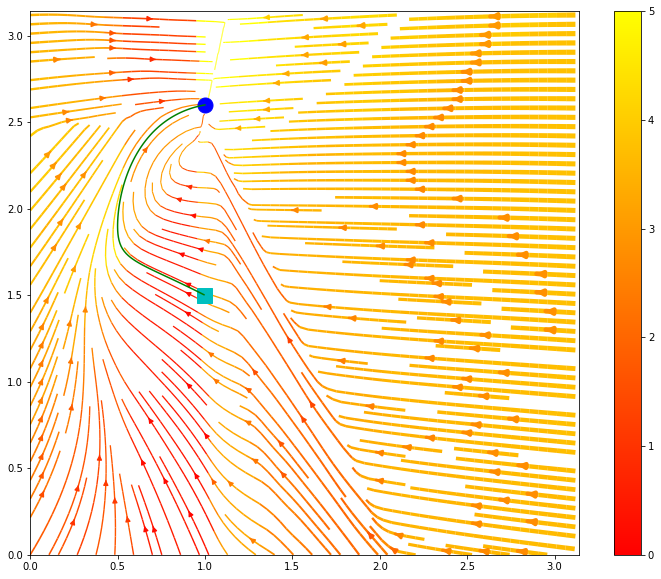

In [7]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_noreg_0306_1.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

C:\Users\BHLee-robotics\Harmonic_Regularization\Libraries\ICNN_plot.py:103: RuntimeWarning: invalid value encountered in arccos
  q1 = np.arccos(((self.l1+self.l2*np.cos(q2))*x1+(self.l2*np.sin(q2))*x2)/(self.l1**2+self.l2**2+2*self.l1*self.l2*np.cos(q2)))


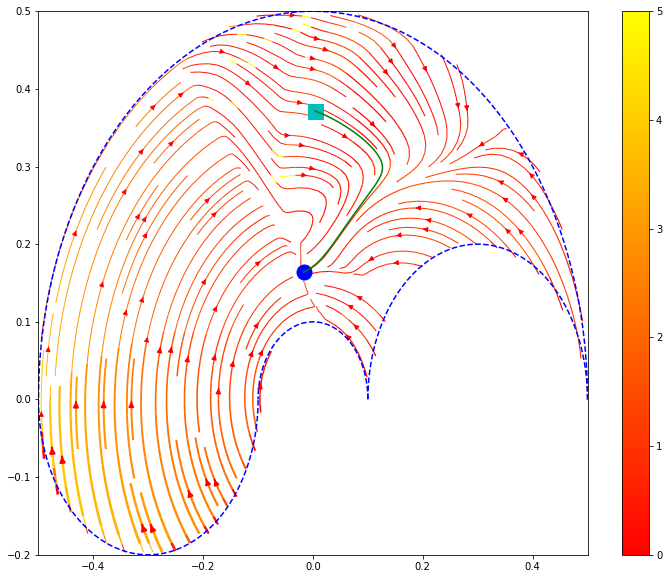

In [8]:
plt_.plot_f_taskspace('task_plot_0306_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)

## weight norm decay

In [9]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [10]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000)

 epoch = 156, loss = 0.007306448, loss_b = 0.0, loss_t = 0.007306448                    . .  ..                                                                                                                                                      

KeyboardInterrupt: 

In [9]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000,weight_decay = 1e-4)

 epoch = 4214, loss = 0.0008497246, loss_b = 0.00018258458, loss_t = 0.0008496912                    ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

KeyboardInterrupt: 

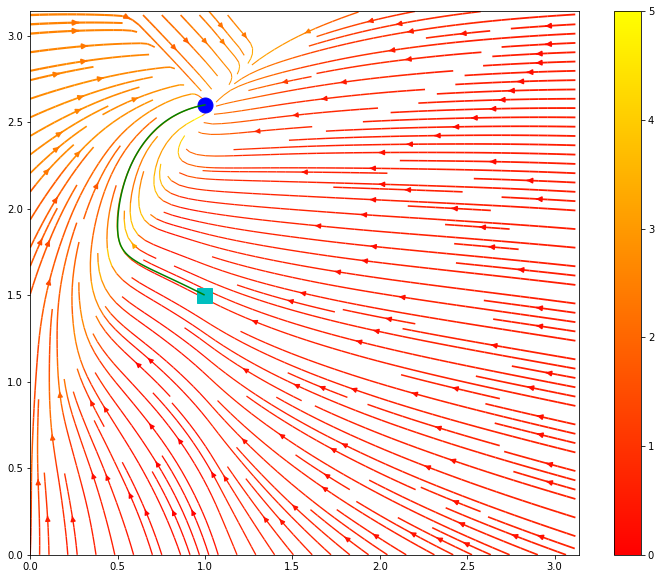

In [10]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_noreg_0306_1.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

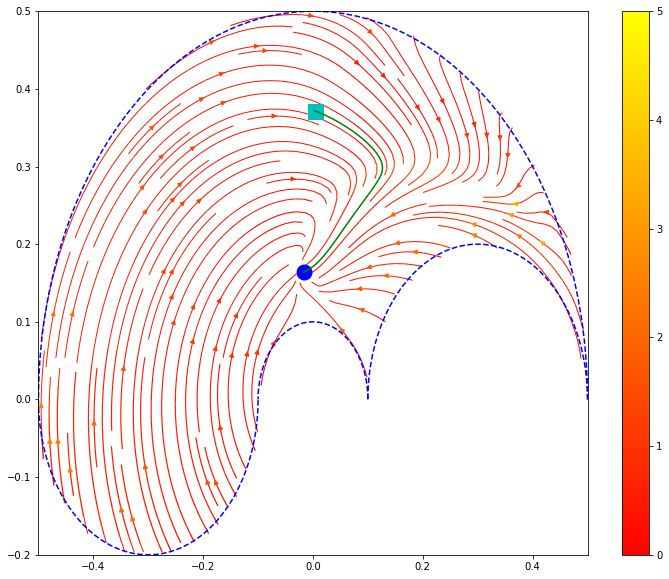

In [11]:
plt_.plot_f_taskspace('task_plot_0306_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)

# Euclidean Regularization

In [16]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [17]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000)

 epoch = 699, loss = 0.0007015482, loss_b = 0.0, loss_t = 0.0007015482                    . .  .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

KeyboardInterrupt: 

In [18]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=10000,weight_decay = 1e-4)

 epoch = 106, loss = 0.00056326756, loss_b = 0.0, loss_t = 0.00056326756                    .                                                                                                      

KeyboardInterrupt: 

In [12]:
#optimization for Euclidean regularizer
#mode 0: exp barrier, 1: relu squared
mode = 2
optim_.optim_Euc_reg(q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, learning_rate = 5e-5,epoch=100, batch_size = 40,penalty_mode = mode)

 epoch = 99 i = 250, loss = 5769.222, total_loss = 5766.0015, loss_b = 0.0, loss_t = 7.0231436e-05, loss_reg = 11.003445, loss_reg_total =  7.726268           ....    .......                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

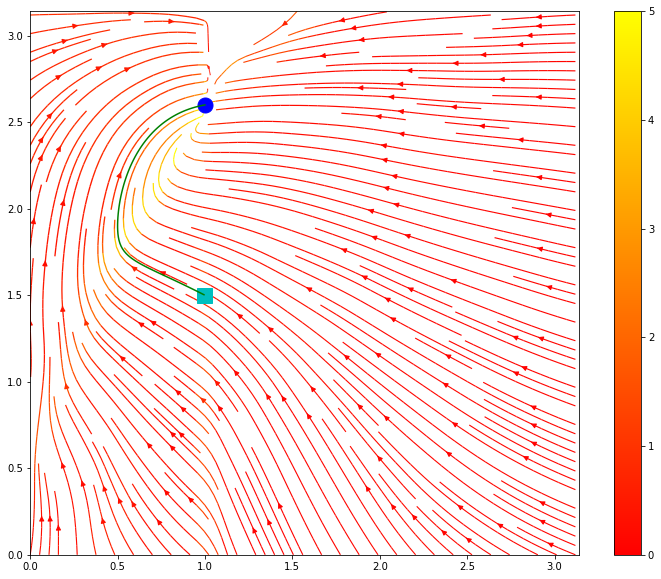

In [13]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_noreg_0306_1.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

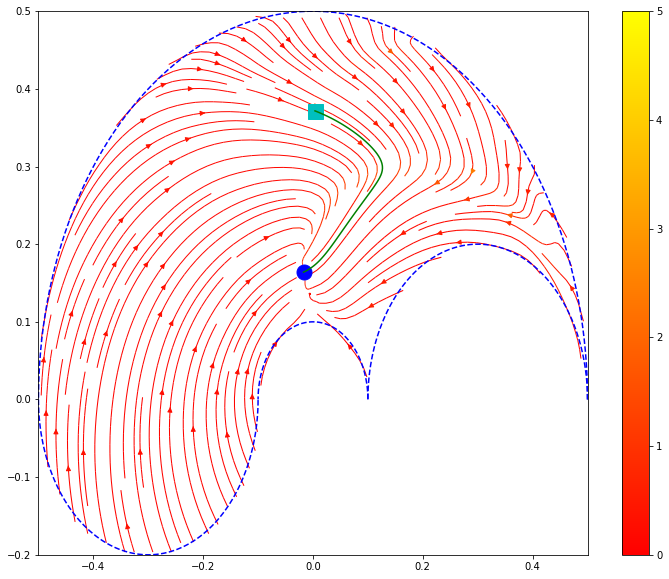

In [14]:
plt_.plot_f_taskspace('task_plot_0306_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)

# Kinematic Regularization

In [18]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [19]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000)

 epoch = 258, loss = 0.005959592, loss_b = 0.0, loss_t = 0.005959592                    . .       .                                                                                                                                                                                                                                                         

KeyboardInterrupt: 

In [20]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-4 ,epoch=1000,weight_decay = 1e-4)

 epoch = 801, loss = 0.00031313286, loss_b = 0.0, loss_t = 0.00031313286                    .         ..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

KeyboardInterrupt: 

In [ ]:
#optimization for Euclidean regularizer
#mode 0: exp barrier, 1: relu squared
mode = 1
optim_.optim_Kinematic_reg(robot, q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, Xstable,alpha_kinematic, learning_rate = 3e-5,epoch=150, batch_size = 40,penalty_mode = mode)

 epoch = 7 i = 240, loss = 282.81885, total_loss = 287.75253, loss_b = 0.006918057, loss_t = 0.33579254, loss_reg = 0.042276636, loss_reg_total =  0.048165113           ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

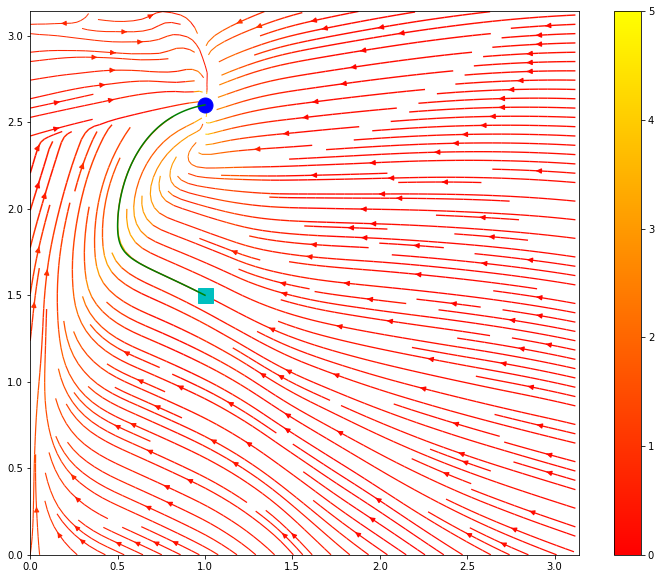

In [12]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_noreg_0306_1.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

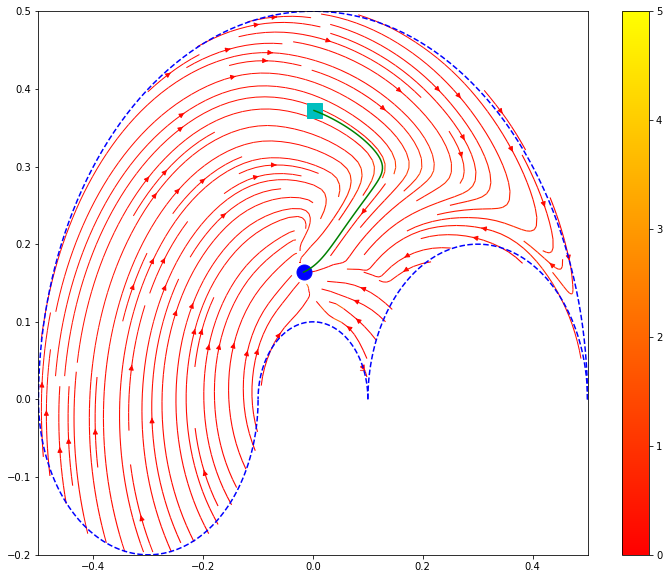

In [13]:
plt_.plot_f_taskspace('task_plot_0306_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)

# Kinetic Regularization

In [25]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device)
q_in_reg,q1,q2 = optim_.get_grid(nq1,nq2,qmin,qmax)

In [26]:
#no regularization
optim_.optim_no_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000)

 epoch = 5357, loss = 0.00067470147, loss_b = 0.0, loss_t = 0.00067470147                    .  .. ..  ..                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

KeyboardInterrupt: 

In [27]:
#####################################################################
#weight regularization
optim_.optim_weight_reg(qtraj,q_dot,dt,q_in_boundary,q_dot_boundary, learning_rate = 1e-3 ,epoch=10000,weight_decay = 1e-4)

 epoch = 1145, loss = 0.0002940032, loss_b = 0.0, loss_t = 0.0002940032                    . .     .....                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

KeyboardInterrupt: 

In [14]:
#optimization for Euclidean regularizer
#mode 0: exp barrier, 1: relu squared
optim_.optim_Kinetic_reg(robot, q_in_reg,qtraj ,q_dot,dt,q_in_boundary,q_dot_boundary,penalty,penalty_boundary, Xstable, learning_rate = 5e-5,epoch=100, batch_size = 40,penalty_mode = 2)

 epoch = 3 i = 57, loss = 11532.971, total_loss = 11533.375, loss_b = 0.0, loss_t = 0.00039645116, loss_reg = 0.18396221, loss_reg_total =  0.551786           ......     .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

KeyboardInterrupt: 

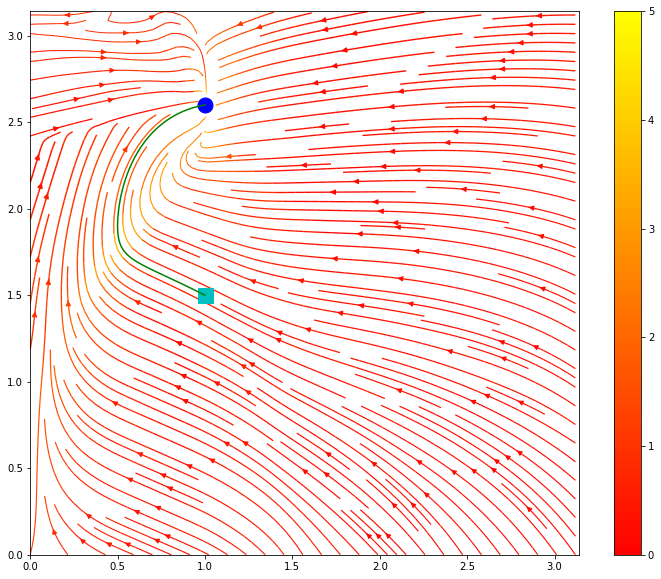

In [15]:
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)
plt_.plot_f('fplot_noreg_0306_1.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

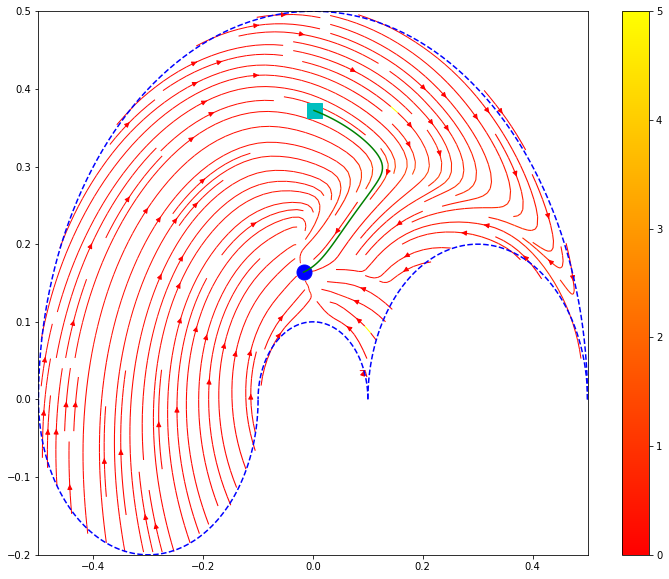

In [16]:
plt_.plot_f_taskspace('task_plot_0306_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)

In [51]:
nq1_p = 100
nq2_p = 100
nx1 = 100
nx2 = 100
xmin = [-robot.l1-robot.l2, -robot.l2]
xmax = [robot.l1+robot.l2,robot.l1+robot.l2]
plt_ = pl.ICNN_plot(optim_.model,qmin,qmax,nq1_p,nq2_p,xmin,xmax,nx1,nx2,Xstable,qtraj,xtraj,l1,l2,device)

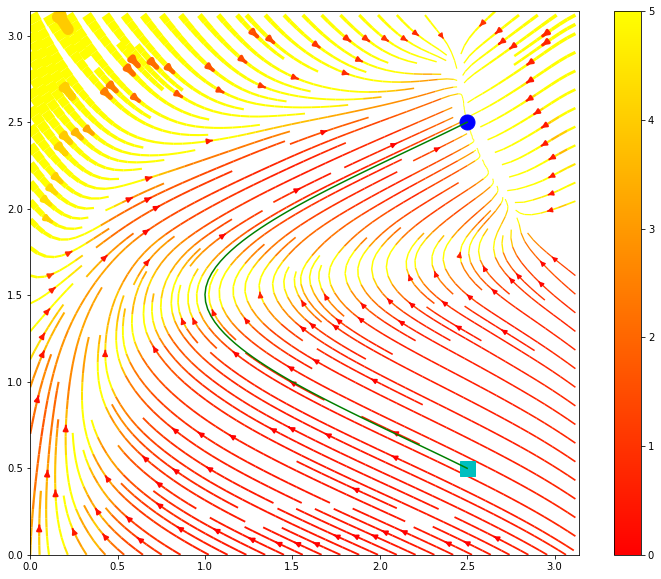

In [54]:
plt_.plot_f('fplot_noreg_0306_1.png', 2, .5, 1, quiver = False, streamplot = True,cmax=5)

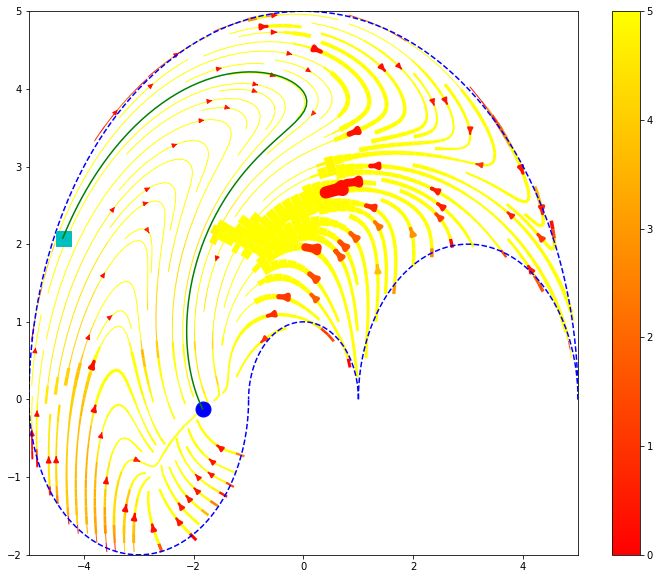

In [55]:
plt_.plot_f_taskspace('task_plot_0306_1.png', robot, 2,  0.5,  1, quiver = False, streamplot = True,cmax=5)

In [ ]:
# initialization
optim_ = opt.ICNN_optim(V_hidden_sizes, fhat_hidden_sizes,tol,alpha,Xstable,device)

In [11]:
plt_.plot_V('t.png',3)

AttributeError: 'ICNN_net' object has no attribute 'fh_forward'